Configuración e Importaciones

In [1]:
# Importaciones
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
import os
import joblib
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

# Carga del modelo de spacy y semilla
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print('Descargando el modelo en_core_web_sm de spaCy...')
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')
seed = 42


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.width', 200)


Carga y Preprocesamiento de Datos

In [10]:

try:
    # 1. Definir los parámetros
    ruta_archivo = 'data/training.1600000.processed.noemoticon.csv'
    total_filas = 1600000
    filas_a_leer = 1600000 # pocos inputs para las pruebas de codigo
    
    # 2. Calcular cuántas filas necesitamos omitir
    filas_a_omitir = total_filas - filas_a_leer

    # 3. Generar una lista aleatoria de índices de fila para omitir
    # Creamos una lista de todos los posibles índices (del 0 al 1,599,999) y elegimos al azar.
    indices_a_omitir = random.sample(range(total_filas), k=filas_a_omitir)

    # 4. Cargar el CSV omitiendo los índices que calculamos
    # Como no hay encabezado (header=None), los índices de las filas empiezan en 0.
    df = pd.read_csv(
        ruta_archivo,
        encoding='latin-1',
        header=None,
        skiprows=indices_a_omitir
    )
    print(f"✅ DataFrame cargado con {len(df)} filas.")
    
    # Asignar nombres a las columnas
    df.columns = ['Sentiment', 'id', 'date', 'query', 'user', 'Text']
    
    # Eliminar columnas innecesarias
    cols_to_drop = ['id', 'date', 'query']
    df = df.drop(columns=cols_to_drop)
    
    print("\nProcesamiento inicial completado.")
    print(df.sample(10))
    
except FileNotFoundError:
    print(f"Error: El archivo no fue encontrado en la ruta: {ruta_archivo}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

if 'df' in locals():
    df['Sentiment'] = df['Sentiment'].map({0: 'Negative', 4: 'Positive', 2: 'Neutro??'})
    df_copy = df.copy()

    print('Distribución de sentimientos tras el mapeo:')
    print(df['Sentiment'].value_counts())

✅ DataFrame cargado con 1600000 filas.

Procesamiento inicial completado.
         Sentiment             user                                                                                                                     Text
1166456          4  toastedfrenchie                                                                          @SpiceBabyBA LOL!! Good morning Canadian lover 
617591           0     melissaxrock    @mellicherry haha, yeah i'd love to move to USA !  new neighbours for Zac Efron xD where I live, it's boring as well 
1256331          4      JBlover1494                          @jonas_twilight3 lol thank you!!!!!!!!!!!! you got me my 100th follower  a shoe??? lol nice....
874357           4      patrickbloy                                                                                                   looking for some food 
1527713          4   JonasBrosCraze  @ddlovato I just wish that I lived in England so I would see you or the Jonas Brothers. Good Luck for yo

Análisis Exploratorio de Datos (EDA)

Generando nubes de palabras... poco útil, pero bonita


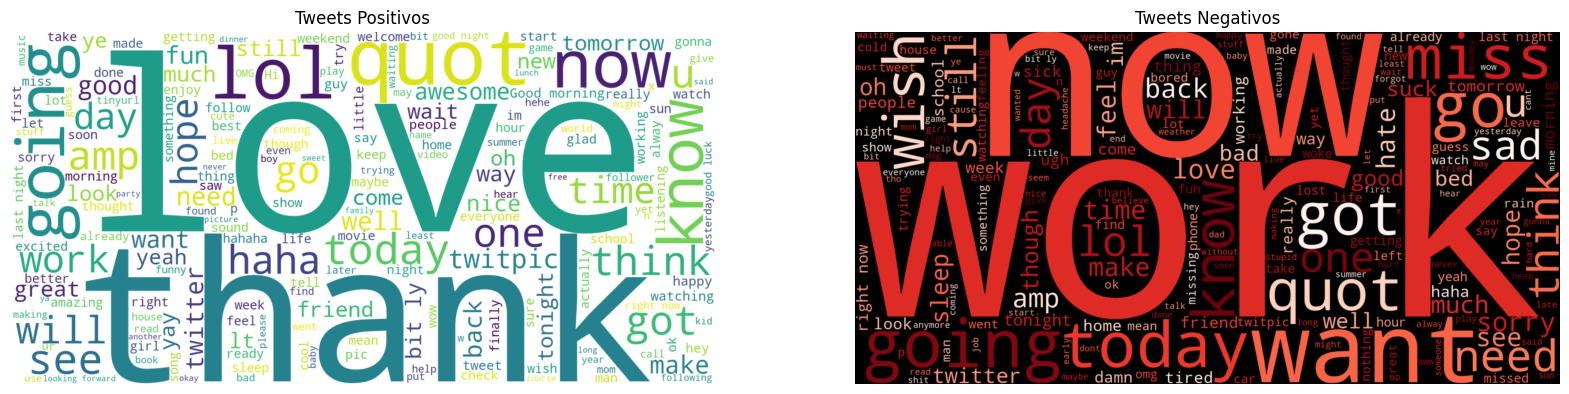

In [11]:
# Nube de Palabras
if 'df_copy' in locals():
    print("Generando nubes de palabras... poco útil, pero bonita")
    positive_tweets = df_copy[df_copy['Sentiment'] == 'Positive']['Text'].str.cat(sep=' ')
    negative_tweets = df_copy[df_copy['Sentiment'] == 'Negative']['Text'].str.cat(sep=' ')

    wordcloud_pos = WordCloud(width=1600, height=800, background_color='white').generate(positive_tweets)
    wordcloud_neg = WordCloud(width=1600, height=800, background_color='black', colormap='Reds').generate(negative_tweets)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.title('Tweets Positivos')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.title('Tweets Negativos')
    plt.axis('off')
    plt.show()

### Preparación para el Modelo | Se intenta cargar el split_data.joblib, si no se logra, se ejecuta la limpieza y se guarda.

In [4]:
# Intenta cargar los datos preprocesados 
try:
    ruta_archivo_joblib = 'data_processed/split_data_cleaned_1.6kk.joblib'
    datos_cargados = joblib.load(ruta_archivo_joblib)
    X_train_limpio = datos_cargados['X_train_limpio']
    X_test_limpio = datos_cargados['X_test_limpio']
    y_train = datos_cargados['y_train']
    y_test = datos_cargados['y_test']
    print("✅ Datos preprocesados y limpios cargados exitosamente desde el archivo.")

# Si no los encuentra, ejecuta la división, limpieza y guardado 
except FileNotFoundError:
    print("⚠️ Archivo no encontrado. Ejecutando el preprocesamiento completo...")
    if 'df' in locals():
        def limpieza(texto):
            if not isinstance(texto, str):
                return ""
            texto = texto.lower()
            texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
            texto = re.sub(r'\s+', ' ', texto).strip()
            if not texto:
                return ""
            doc = nlp(texto)
            return ' '.join([token.lemma_ for token in doc if not token.is_stop])

        # Definir X e y a partir del DataFrame CRUDO
        X = df['Text']
        y = df['Sentiment'].map({'Negative': -1, 'Positive': 1})

        # Dividir los datos CRUDOS en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
        print("📊 Datos divididos en conjuntos de entrenamiento y prueba.")

        # Aplicar la limpieza POR SEPARADO a cada conjunto
        print("🧹 Limpiando los datos de entrenamiento y prueba...")
        X_train_limpio = X_train.apply(limpieza)
        X_test_limpio = X_test.apply(limpieza)
        
        # Guardado de los datos ya divididos y limpios
        output_dir = 'data_processed'
        os.makedirs(output_dir, exist_ok=True)
        # Cambiamos el nombre para reflejar que los datos están limpios
        output_path = os.path.join(output_dir, 'split_data_cleaned_prueba.joblib')
        
        joblib.dump({
            'X_train_limpio': X_train_limpio, 
            'X_test_limpio': X_test_limpio, 
            'y_train': y_train, 
            'y_test': y_test
        }, output_path)
        print(f"💾 Datos procesados y guardados en: '{output_path}'")
    else:
        print("❌ Error: El DataFrame 'df' no está definido. Asegúrate de cargarlo primero.")

✅ Datos preprocesados y limpios cargados exitosamente desde el archivo.


Entrenamiento y Evaluación del Modelo

Paso 1: Realizando vectorización TF-IDF optimizada...
Vectorización completada.

Paso 2: Iniciando búsqueda de hiperparámetros con GridSearchCV...
Mejores parámetros encontrados: {'C': 0.5}

Paso 3: Evaluando el mejor modelo encontrado...

--- Reporte de Clasificación (Train) ---
              precision    recall  f1-score   support

          -1       0.80      0.76      0.78    560000
           1       0.77      0.81      0.79    560000

    accuracy                           0.78   1120000
   macro avg       0.78      0.78      0.78   1120000
weighted avg       0.78      0.78      0.78   1120000


--- Reporte de Clasificación (Test) ---
              precision    recall  f1-score   support

          -1       0.79      0.75      0.77    240000
           1       0.76      0.80      0.78    240000

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



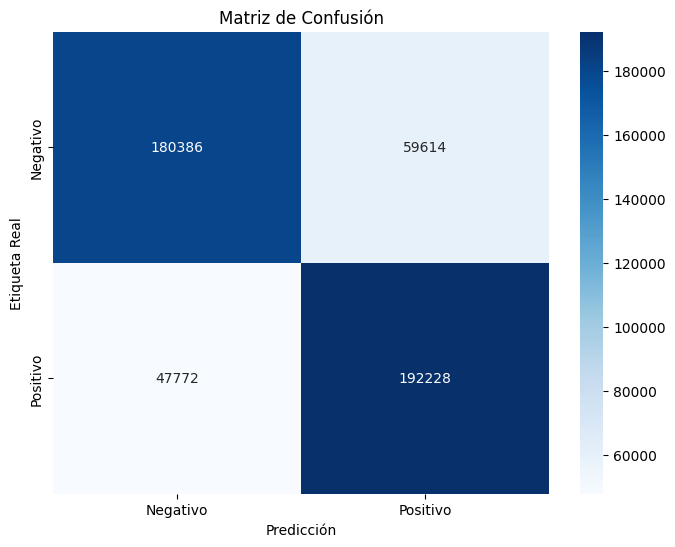


✅ ¡Éxito! Modelo y vectorizador guardados en la carpeta 'model_pruebas'.


In [5]:
# Vectorización, Optimización, Evaluación y Guardado

print("Paso 1: Realizando vectorización TF-IDF optimizada...")
# Usamos las variables con los datos ya limpios
vectorizer_tfidf_opt = TfidfVectorizer(ngram_range=(1, 2), max_features=20000, min_df=5, max_df=0.7)
X_train_tfidf_opt = vectorizer_tfidf_opt.fit_transform(X_train_limpio)
X_test_tfidf_opt = vectorizer_tfidf_opt.transform(X_test_limpio)
print("Vectorización completada.")

print("\nPaso 2: Iniciando búsqueda de hiperparámetros con GridSearchCV...")
model_lr = LogisticRegression(random_state=seed, max_iter=1000)
param_grid = {'C': [0.1, 0.5, 1]}
grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_tfidf_opt, y_train)
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

# Evaluando el mejor modelo encontrado 
print("\nPaso 3: Evaluando el mejor modelo encontrado...")
best_model_lr = grid_search.best_estimator_

#  Reporte de Clasificación (Train) 
print("\n--- Reporte de Clasificación (Train) ---")
y_train_pred = best_model_lr.predict(X_train_tfidf_opt)
print(classification_report(y_train, y_train_pred))

# Reporte de Clasificación (Test) 
print("\n--- Reporte de Clasificación (Test) ---")
y_test_pred = best_model_lr.predict(X_test_tfidf_opt)
print(classification_report(y_test, y_test_pred))

# Matriz de Confusión 
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

# Guardado del Modelo y Vectorizador Final
output_dir = 'model_pruebas'
os.makedirs(output_dir, exist_ok=True)
joblib.dump(vectorizer_tfidf_opt, os.path.join(output_dir, 'schimizzi_vectorizer_prueba.joblib'))
joblib.dump(best_model_lr, os.path.join(output_dir, 'schimizzi_modelo_prueba.joblib'))
print(f"\n✅ ¡Éxito! Modelo y vectorizador guardados en la carpeta '{output_dir}'.")

In [6]:
import pandas as pd
import numpy as np

print("\n--- Top 20 Palabras Más Relevantes (TF-IDF) ---")

# Asegurarnos de que los objetos del modelo optimizado existan
if 'vectorizer_tfidf_opt' in locals() and 'X_train_tfidf_opt' in locals():
    # 1. Obtenemos el puntaje TF-IDF promedio para cada palabra
    # Esto nos da una idea de la importancia general de cada término en el corpus
    avg_tfidf_scores = np.asarray(X_train_tfidf_opt.mean(axis=0)).ravel()
    
    # 2. Creamos un DataFrame con las palabras y sus puntajes promedio
    df_relevancia = pd.DataFrame({
        'palabra': vectorizer_tfidf_opt.get_feature_names_out(),
        'relevancia_tfidf': avg_tfidf_scores
    })
    
    # 3. Ordenamos por relevancia y mostramos las 20 más importantes
    df_relevancia_ordenada = df_relevancia.sort_values(by='relevancia_tfidf', ascending=False)
    
    print(df_relevancia_ordenada.head(20))
else:
    print("⚠️ Error: El 'vectorizer_tfidf_opt' o 'X_train_tfidf_opt' no están definidos.")
    print("Asegúrate de haber ejecutado la celda del modelo optimizado (GridSearchCV).")


--- Top 20 Palabras Más Relevantes (TF-IDF) ---
      palabra  relevancia_tfidf
11593     not          0.021866
6067     good          0.013209
5818       go          0.012929
3166      day          0.012338
19350    work          0.011832
5435      get          0.011259
16356   thank          0.010947
9684     love          0.010411
9040     like          0.010098
10490    miss          0.009560
17145   today          0.008627
18547    want          0.008543
8556     know          0.008403
16824    time          0.008301
16569   think          0.008147
9404      lol          0.007971
4623     feel          0.007109
2481     come          0.006516
18733   watch          0.006347
11089    need          0.006329


In [7]:
#  Top 20 Palabras Más Frecuentes 
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

print("--- Top 20 Palabras Más Frecuentes ---")

# Asegurarnos de que X_train_limpio exista
if 'X_train_limpio' in locals():
    # 1. Usamos CountVectorizer para contar la frecuencia de cada palabra
    count_vectorizer = CountVectorizer()
    # CORRECCIÓN: Usar la variable con los datos ya limpios
    word_counts = count_vectorizer.fit_transform(X_train_limpio)
    
    # 2. Sumamos las apariciones de cada palabra en todos los documentos
    total_counts = word_counts.sum(axis=0)
    
    # 3. Creamos un DataFrame para visualizar los resultados
    df_frecuencia = pd.DataFrame({
        'palabra': count_vectorizer.get_feature_names_out(),
        'frecuencia': total_counts.getA1()
    })
    
    # 4. Ordenamos por frecuencia y mostramos las 20 más comunes
    df_frecuencia_ordenada = df_frecuencia.sort_values(by='frecuencia', ascending=False)
    
    print(df_frecuencia_ordenada.head(20))

else:
    print("⚠️ Error: La variable 'X_train_limpio' no está definida. Asegúrate de haber ejecutado la celda de preprocesamiento.")

--- Top 20 Palabras Más Frecuentes ---
       palabra  frecuencia
387230     not      164142
179401      go       78620
180764    good       73423
112567     day       72655
175338     get       67689
580117    work       59327
316190    like       57681
325069    love       52163
536414   today       45608
533363    time       44537
529569   think       41577
300559    know       40750
567344    want       39820
354983    miss       39348
522827   thank       39052
321962     lol       38627
156174    feel       34369
94285     come       31132
382214   night       30471
377327    need       30064


### Uso del Modelo Guardado para Predicciones

In [8]:
# Cargar el modelo de lenguaje de Spacy 
# Esto es necesario para que la función 'limpieza' funcione.
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print('Descargando el modelo en_core_web_sm de spaCy...')
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# Definir la función de limpieza 
# Esta debe ser la misma función que usaste para entrenar el modelo.
def limpieza(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    if not texto:
        return ""
    doc = nlp(texto)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])

# Cargar el modelo y el vectorizador guardados 
try:
    vectorizer_cargado = joblib.load('model_robust/schimizzi_vectorizer_1.6kk.joblib')
    modelo_cargado = joblib.load('model_robust/schimizzi_modelo_1.6kk.joblib')
    print("Vectorizer y modelo cargados correctamente.\n")

    # Preparar y predecir sobre datos nuevos 
    df_nuevos = pd.read_csv('data/testdata.manual.2009.06.14.csv', header=None, encoding='latin-1')
    df_nuevos.columns = ['Sentiment', 'id', 'date', 'query', 'user', 'Text']
    
    # Aplicar la limpieza a los nuevos datos
    nuevos_datos_limpios = df_nuevos['Text'].apply(limpieza)
    
    # Transformar los datos limpios con el vectorizador cargado
    nuevos_datos_tfidf = vectorizer_cargado.transform(nuevos_datos_limpios)
    
    # Realizar la predicción
    predicciones = modelo_cargado.predict(nuevos_datos_tfidf)
    
    # Añadir resultados al DataFrame
    mapa_sentimiento = {-1: "Negativo", 1: "Positivo"}
    df_nuevos['Prediccion'] = [mapa_sentimiento[p] for p in predicciones]
    
    print("--- Muestra de Predicciones sobre Datos Nuevos ---")
    print(df_nuevos[['user', 'Text', 'Prediccion']].sample(10))
    
except FileNotFoundError:
    print("\nError: Asegúrate de que los archivos 'schimizzi_vectorizer_prueba.joblib' y 'schimizzi_modelo_prueba.joblib' estén en la carpeta 'model_pruebas'.")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")


Vectorizer y modelo cargados correctamente.

--- Muestra de Predicciones sobre Datos Nuevos ---
                user                                                                                                                     Text Prediccion
173  LouisvilleGrads                                                 Cardinals baseball advance to Super Regionals. Face CS-Fullerton Friday.   Positivo
284          rayceja                                                                                                 Heading to San Francisco   Positivo
19         Native_01                                                                                              @Pmillzz lebron IS THE BOSS   Negativo
92    AntoineTheReaL  wish i could catch every mosquito in the world n burn em slowly.they been bitin the shit outta me 2day.mosquitos are...   Negativo
244        motsandco                                       ' Barack Obama shows his funny side " &gt;&gt; http://tr.im/l0gY !! Great speech

### Descargar la predicción a un archivo Excel

In [9]:
# Crear un DataFrame con el usuario, el texto original y la predicción
df_resultados = df_nuevos[['user', 'Text', 'Prediccion']].copy()

# Renombrar las columnas para el archivo de salida (ajustando a minúsculas)
df_resultados.rename(columns={'Text': 'text', 'Prediccion': 'prediccion'}, inplace=True)

# Guardar el DataFrame en un archivo Excel
nombre_archivo_excel = 'predict/predicciones_finales.xlsx'
df_resultados.to_excel(nombre_archivo_excel, index=False)
print(f"Las predicciones se han guardado correctamente en el archivo: '{nombre_archivo_excel}'")



Las predicciones se han guardado correctamente en el archivo: 'predict/predicciones_finales.xlsx'
